In [120]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
import geopandas as gpd
from src.organized_datasets_creation.utils import resolve_nominatim_city_name
from src.graph_layering.graph_layer_creator import GraphLayerController
import pandas as pd
import os
from src.graph_layering.graph_layer_creator import SourceType
import warnings
from src.graph_layering.create_hetero_data import create_hetero_data
from sklearn.preprocessing import OneHotEncoder
from typing import cast
from tqdm import tqdm

import wandb.util
import wandb
import os


import numpy as np
from src.graph.create_osmnx_graph import OSMnxGraph
import json
from shapely.geometry import Point
from joblib import dump


from datetime import datetime
from sklearn.metrics import f1_score, roc_auc_score
from wandb.util import generate_id
from sklearn.linear_model import LogisticRegression
from src.training.train import train
from sklearn.preprocessing import StandardScaler

In [122]:
WANDB_API_KEY = os.environ.get(
    "WANDB_API_KEY", "d9a5ea2376eb22e50a1958ced2e5488f544362f2"
)
assert (
    WANDB_API_KEY is not None
), "WANDB_API_KEY is not set, did you forget it in the config file?"

In [123]:
# general settings
ORGANIZED_HEXES_LOCATION = "/mnt/m2-mint/gradient/gradient/data/organized-hexes"
ORGANIZED_GRAPHS_LOCATION = "/mnt/m2-mint/gradient/gradient/data/organized_graphs"
OSMNX_ALL_ATTRIBUTES_LOCATION = (
    "/mnt/m2-mint/gradient/gradient/data/osmnx_attributes.json"
)

# downstream task settings
AIRBNB_LOCATION = "/mnt/m2-mint/gradient/gradient/data/downstream_tasks/airbnb"
TRAIN_SAVE_DIR = "/mnt/m2-mint/gradient_logs"

SWEEP_RUNS_COUNT = 2

ATTRIBUTES_CONFIGURATIONS = [
    # {
    #     "USE_ORTOPHOTO": False,
    #     "USE_HEXES_ATTRS": True,
    #     "USE_OSMNX_ATTRS": True,
    # },
    {
        "USE_ORTOPHOTO": False,
        "USE_HEXES_ATTRS": True,
        "USE_OSMNX_ATTRS": False,
    },
    # {
    #     "USE_ORTOPHOTO": False,
    #     "USE_HEXES_ATTRS": False,
    #     "USE_OSMNX_ATTRS": True,
    # },
]

WANDB_SWEEP_PARAMS_GRAPH_DATA = {
    "method": "bayes",
    "metric": {"name": "mean_f1", "goal": "maximize"},
    "parameters": {
        "hidden_channels": {"values": [10, 20, 30, 40, 50]},
        "learning_rate": {
            "distribution": "log_uniform_values",
            "min": 1e-5,
            "max": 1e-2,
        },
        "epochs": {
            "distribution": "int_uniform",
            "min": 10,
            "max": 20,
        },
        "num_conv_layers": {"values": [1, 2, 3, 4, 5]},
        "lin_layer_size": {"values": [8, 16, 32, 64, 128]},
        "num_lin_layers": {"values": [0, 1, 2, 3, 4]},
        "weight_decay": {
            "distribution": "log_uniform_values",
            "min": 1e-5,
            "max": 1e-2,
        },
    },
}

WANDB_SWEEP_PARAMS_TABULAR_DATA = {
    "method": "bayes",
    "metric": {"name": "mean_f1", "goal": "maximize"},
    "parameters": {
        "solver_penalty": {
            "values": [
                "lbfgs;l2",
                "liblinear;l1",
                "liblinear;l2",
                "newton-cg;l2",
                "newton-cholesky;l2",
                "sag;l2",
                "saga;elasticnet",
                "saga;l1",
                "saga;l2",
            ]
        },
        "C": {
            "distribution": "log_uniform_values",
            "min": 1e-5,
            "max": 1,
        },
    },
}

# Load airbnb data


In [124]:
def create_gdf_airbnb_price(data):
    gdf = gpd.GeoDataFrame(
        data.drop(["latitude", "longitude"], axis=1),
        geometry=gpd.points_from_xy(x=data["longitude"], y=data["latitude"]),
        crs="EPSG:4326",
    )
    gdf_price = gdf[["geometry", "price"]]
    gdf_price.reset_index(inplace=True, drop=True)

    return gdf_price

In [125]:
airbnb_ny = pd.read_csv(f"{AIRBNB_LOCATION}/airbnb_new_york_cleaned.csv")
airbnb_ny = create_gdf_airbnb_price(airbnb_ny)
airbnb_ny["mie_nazwa"] = "new_york"
airbnb_ny

,geometry,price,mie_nazwa
0,POINT (-73.95512 40.68535),72.0,new_york
1,POINT (-73.99454 40.66265),253.0,new_york
2,POINT (-73.95342 40.70935),81.0,new_york
3,POINT (-73.94255 40.80107),65.0,new_york
4,POINT (-73.94759 40.78778),60.0,new_york
...,...,...,...
23756,POINT (-74.00952 40.71445),721.0,new_york
23757,POINT (-74.00940 40.71647),721.0,new_york
23758,POINT (-74.01149 40.71617),1080.0,new_york
23759,POINT (-73.94935 40.78102),198.0,new_york


In [126]:
airbnb_st = pd.read_csv(f"{AIRBNB_LOCATION}/airbnb_seattle_cleaned.csv")
airbnb_st = create_gdf_airbnb_price(airbnb_st)
airbnb_st["mie_nazwa"] = "seattle"
airbnb_st

,geometry,price,mie_nazwa
0,POINT (-122.33629 47.65444),99.0,seattle
1,POINT (-122.31937 47.55017),72.0,seattle
2,POINT (-122.38663 47.55495),166.0,seattle
3,POINT (-122.38607 47.55627),125.0,seattle
4,POINT (-122.37196 47.67947),81.0,seattle
...,...,...,...
6073,POINT (-122.34716 47.61584),307.0,seattle
6074,POINT (-122.37198 47.70236),145.0,seattle
6075,POINT (-122.34887 47.61576),153.0,seattle
6076,POINT (-122.35028 47.62791),186.0,seattle


In [127]:
airbnb = pd.concat([airbnb_ny, airbnb_st])
airbnb

,geometry,price,mie_nazwa
0,POINT (-73.95512 40.68535),72.0,new_york
1,POINT (-73.99454 40.66265),253.0,new_york
2,POINT (-73.95342 40.70935),81.0,new_york
3,POINT (-73.94255 40.80107),65.0,new_york
4,POINT (-73.94759 40.78778),60.0,new_york
...,...,...,...
6073,POINT (-122.34716 47.61584),307.0,seattle
6074,POINT (-122.37198 47.70236),145.0,seattle
6075,POINT (-122.34887 47.61576),153.0,seattle
6076,POINT (-122.35028 47.62791),186.0,seattle


In [128]:
def add_class_to_df(data: pd.Series):

    q1 = data.quantile(0.25)
    q2 = data.quantile(0.5)
    q3 = data.quantile(0.75)

    bins = [0, q1, q2, q3, float("inf")]
    # label_names = ['low', 'medium', 'high', 'very high']
    label_names = [0, 1, 2, 3]
    return pd.cut(data, bins=bins, labels=label_names, right=True)

In [129]:
# airbnb = add_class_to_df(airbnb)
# airbnb.drop("price", axis=1, inplace=True)

In [130]:
def add_airbnb_to_osmnx_nodes(
    airbnb: gpd.GeoDataFrame,
    nodes: gpd.GeoDataFrame,
    edges: gpd.GeoDataFrame,
    city_name: str,
):
    with open(OSMNX_ALL_ATTRIBUTES_LOCATION) as f:
        all_attributes = json.load(f)

    osmnx_graph = OSMnxGraph(
        airbnb.loc[airbnb["mie_nazwa"] == city_name, :],
        nodes,
        edges,
        all_attributes,
        y_column_name="price",
    )
    osmnx_graph._aggregate(element_type="node", aggregation_method="mean")
    return osmnx_graph.gdf_nodes


def create_gdfs(city_name: str):
    osmnx_nodes = gpd.read_parquet(
        os.path.join(ORGANIZED_GRAPHS_LOCATION, city_name, "nodes.parquet")
    )
    osmnx_nodes = osmnx_nodes.reset_index()
    osmnx_nodes.index.names = ["node_id"]
    osmnx_nodes["x"] = osmnx_nodes["geometry"].x
    osmnx_nodes["y"] = osmnx_nodes["geometry"].y

    osmnx_edges = gpd.read_parquet(
        os.path.join(ORGANIZED_GRAPHS_LOCATION, city_name, "edges.parquet")
    )
    osmnx_edges = osmnx_edges.reset_index().rename(columns={"index": "edge_id"})
    osmnx_edges.index.names = ["edge_id"]
    if "level_4" in osmnx_edges.columns:
        osmnx_edges = osmnx_edges.drop("level_4", axis=1)
    osmnx_edges = osmnx_edges.fillna(0)

    assert osmnx_nodes.crs == osmnx_edges.crs
    assert osmnx_nodes.crs == airbnb.crs

    osmnx_nodes = add_airbnb_to_osmnx_nodes(
        airbnb=airbnb,
        nodes=osmnx_nodes,
        city_name=city_name,
        edges=osmnx_edges,
    )

    hexes_years_folder = os.path.join(ORGANIZED_HEXES_LOCATION, city_name)

    subfolders = [
        int(f)
        for f in os.listdir(hexes_years_folder)
        if os.path.isdir(os.path.join(hexes_years_folder, f))
    ]
    highest_year = subfolders[np.argmax(subfolders)]

    hexes: gpd.GeoDataFrame = gpd.read_parquet(
        os.path.join(
            ORGANIZED_HEXES_LOCATION,
            f"{city_name}/{highest_year}/h9/count-embedder/dataset.parquet",
        )
    )

    hexes = hexes.rename(columns={"region_id": "h3_id"}).rename_axis(
        "region_id", axis=0
    )

    return dict(osmnx_nodes=osmnx_nodes, osmnx_edges=osmnx_edges, hexes=hexes)


print("Creating gdfs...")
gdfs_dict = {
    city_name: create_gdfs(city_name) for city_name in tqdm(["new_york", "seattle"])
}

Creating gdfs...


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


In [131]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for gdf_for_city in gdfs_dict.values():
        gdf_for_city["controller"] = GraphLayerController(
            gdf_for_city["hexes"],
            gdf_for_city["osmnx_nodes"],
            gdf_for_city["osmnx_edges"],
        )

In [132]:
def patch_hexes_with_y(
    osmnx_nodes: gpd.GeoDataFrame,
    hexes: gpd.GeoDataFrame,
    controller: GraphLayerController,
):
    virtual_edges = controller.get_virtual_edges_to_hexes(SourceType.OSMNX_NODES)
    hexes_with_y = cast(
        gpd.GeoDataFrame,
        hexes.merge(
            virtual_edges.merge(osmnx_nodes, left_on="source_id", right_index=True)[
                ["region_id", "price"]
            ]
            .groupby("region_id")
            .mean(),
            left_index=True,
            right_index=True,
            how="left",
        ).fillna(0),
    )
    controller.hexes_gdf = hexes_with_y
    controller._hexes_centroids_gdf = controller._create_hexes_centroids_gdf()

In [133]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for gdfs in gdfs_dict.values():
        patch_hexes_with_y(gdfs["osmnx_nodes"], gdfs["hexes"], gdfs["controller"])

<Axes: >

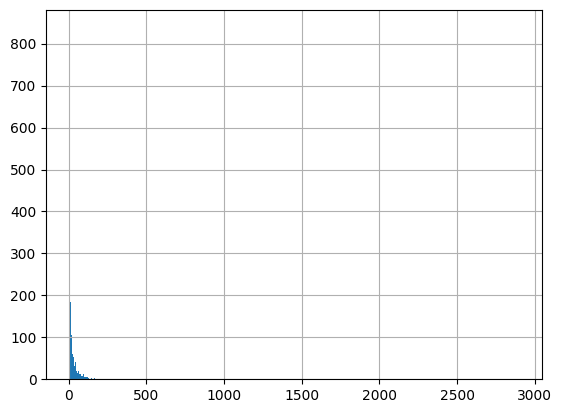

In [138]:
a = gdfs_dict["new_york"]["controller"].hexes_centroids_gdf["price"]
a[a > 0]  # work in progress

In [47]:
def create_graph_data(
    osmnx_nodes,
    osmnx_edges,
    hexes,
    controller: GraphLayerController,
    use_hexes_attr: bool,
    use_ortophoto: bool,
):

    edges_attr_columns = osmnx_edges.columns[
        ~osmnx_edges.columns.isin(["u", "v", "key", "geometry"])
    ]
    nodes_attr_columns = osmnx_nodes.columns[
        ~osmnx_nodes.columns.isin(["geometry", "x", "y", "osmid"])
    ]
    hexes_attr_columns = (
        hexes.columns[~hexes.columns.isin(["geometry", "h3_id", "price_class"])]
        if use_hexes_attr
        else []
    )

    data = create_hetero_data(
        controller,
        hexes_attrs_columns_names=hexes_attr_columns,
        osmnx_edge_attrs_columns_names=edges_attr_columns,
        osmnx_node_attrs_columns_names=nodes_attr_columns,
        virtual_edge_attrs_columns_names=[],
        hexes_y_columns_names=["price_class"],
    )
    return data


graph_data_dict = {
    city_name: create_graph_data(**gdfs, use_ortophoto=False, use_hexes_attr=True)
    for city_name, gdfs in gdfs_dict.items()
}

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [ ]:
def create_tabular_data(
    hexes: pd.DataFrame,
    controller: GraphLayerController,
    use_hexes_attr: bool,
    use_ortophoto: bool,
):
    assert use_ortophoto or use_hexes_attr, "Provide at least one data source"

    hexes_attr_columns = (
        hexes.columns[~hexes.columns.isin(["geometry", "h3_id"])]
        if use_hexes_attr
        else []
    )

    hexes_y_columns_names = ["price_class"]

    X = hexes[hexes_attr_columns]
    y = controller.hexes_centroids_gdf[hexes_y_columns_names]

    return {"X": X, "y": y}


tabular_data_dict = {
    city_name: create_tabular_data(
        gdfs["hexes"], gdfs["controller"], use_ortophoto=False, use_hexes_attr=True
    )
    for city_name, gdfs in gdfs_dict.items()
}

In [ ]:
def shift_elements_right(lst):
    shifted_lst = [lst[-1]] + lst[:-1]
    return shifted_lst


cities_names_list = list(graph_data_dict.keys())
cities_names_list.sort(key=lambda x: str(x))

# val + test
folds_tuples = list(zip(shift_elements_right(cities_names_list), cities_names_list))
display(folds_tuples)

[('seattle', 'new_york'), ('new_york', 'seattle')]

In [ ]:
display(tabular_data_dict["seattle"]["y"].iloc[:, 0].unique())
display(tabular_data_dict["seattle"]["y"].iloc[:, 0].unique())

array([0., 3.])

array([0., 3.])

In [37]:
from typing import cast
from wandb.sdk.wandb_run import Run
import torch


def run_k_fold_graph_data(closure_config, sweep_id):
    # pass external config (i.e. what attributes are used in the data), closure to avoid passing it to the function directly
    def wrapped():
        run: Run = cast(Run, wandb.init())

        config = wandb.config

        for k, v in closure_config.items():
            run.log({k: 1 if v else 0})

        run.log({"data_structure": "graph"})

        # create hparams
        if hasattr(config, "lin_layer_size") and hasattr(config, "num_lin_layers"):
            lin_layer_sizes = [config.lin_layer_size] * config.num_lin_layers
        else:
            lin_layer_sizes = config.lin_layer_sizes
        hparams = {
            "hidden_channels": config.hidden_channels,
            "lr": config.learning_rate,
            "num_conv_layers": config.num_conv_layers,
            "lin_layer_sizes": lin_layer_sizes,
            "weight_decay": config.weight_decay,
        }

        epochs = config.epochs

        aucs = []
        accuracies = []
        f1s = []

        fold_group_id = generate_id()

        # log data as artifact if no data was logged in the sweep before
        # dataset is uploaded only on the first run in sweep, because it does not change across runs in sweep
        # in wandb, dataset will be visible on the first run in the sweep
        artifact_path = os.path.join(TRAIN_SAVE_DIR, f"graph_data_{sweep_id}.pkl")
        if not os.path.exists(artifact_path):
            dump(
                graph_data_dict,
                artifact_path,
                protocol=5,
            )
            artifact = wandb.Artifact(
                name="graph_data", type="dataset", metadata=closure_config
            )
            artifact.add_file(local_path=artifact_path)
            run.log_artifact(artifact)

        # run k-fold
        for index, (_, test_city_name) in enumerate(folds_tuples):
            # prepare data
            train_data = [
                v.to("cpu").clone()
                for k, v in graph_data_dict.items()
                if k != test_city_name
            ]
            test_data = graph_data_dict[test_city_name].to("cpu").clone()

            # run training with checkpointing on lowest val_loss, return test metrics for the best model and its path
            # builtin preprocessing - scaling to N(0, 1)
            auc, accuracy, f1, model_path = train(
                train_data=train_data,
                val_data=None,
                test_data=test_data,
                epochs=epochs,
                hparams=hparams,
                train_save_dir=TRAIN_SAVE_DIR,
                num_classes=torch.unique(train_data[0]["hex"].y).shape[0],
            )

            # logging - single fold
            run.log_model(
                path=model_path,
                name=f"model_{fold_group_id}_fold_{index}",
            )
            run.log({f"auc_fold_{index}": auc})
            run.log({f"accuracy_fold_{index}": accuracy})
            run.log({f"f1_fold_{index}": f1})

            aucs.append(auc)
            accuracies.append(accuracy)
            f1s.append(f1)

        # logging - summary statistics
        mean_auc = sum(aucs) / len(aucs)
        mean_accuracy = sum(accuracies) / len(accuracies)
        mean_f1 = sum(f1s) / len(f1s)
        run.log({"mean_auc": mean_auc})
        run.log({"mean_accuracy": mean_accuracy})
        run.log({"mean_f1": mean_f1})

    return wrapped


def run_k_fold_tabular_data(closure_config, sweep_id):
    # analogously to the graph data, but for tabular data
    def wrapped():
        run: Run = cast(Run, wandb.init())

        config = wandb.config

        for k, v in closure_config.items():
            run.log({k: 1 if v else 0})

        run.log({"data_structure": "tabular"})

        hparams = {}
        hparams["C"] = config["C"]
        solver, penalty = config["solver_penalty"].split(";")
        hparams["solver"] = solver
        if penalty == "None":
            penalty = None
        hparams["penalty"] = penalty

        aucs = []
        accuracies = []
        f1s = []

        fold_group_id = generate_id()

        # log data as artifact
        artifact_path = os.path.join(TRAIN_SAVE_DIR, f"tabular_data_{sweep_id}.pkl")

        if not os.path.exists(artifact_path):
            dump(
                tabular_data_dict,
                artifact_path,
                protocol=5,
            )
            artifact = wandb.Artifact(
                name="tabular_data", type="dataset", metadata=closure_config
            )
            artifact.add_file(local_path=artifact_path)
            run.log_artifact(artifact)

        timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

        for index, test_city_name in enumerate(cities_names_list):
            scaler = StandardScaler()
            X = pd.concat(
                [
                    m["X"]
                    for key, m in tabular_data_dict.items()
                    if key != test_city_name
                ]
            ).to_numpy()
            y = (
                pd.concat(
                    [
                        m["y"]
                        for key, m in tabular_data_dict.items()
                        if key != test_city_name
                    ]
                )
                .to_numpy()
                .ravel()
            )
            print(np.unique(y))

            X = scaler.fit_transform(X)

            logistic_regression = LogisticRegression(
                C=hparams["C"],
                # solver=hparams["solver"],
                # penalty=hparams["penalty"],
                solver="newton-cholesky",
                penalty="l2",
                dual=False,
                tol=1e-4,
                fit_intercept=True,
                intercept_scaling=1,
                class_weight="balanced",
                random_state=1124,
                max_iter=2,
                multi_class="auto",
                warm_start=False,
                n_jobs=-1,
                l1_ratio=0.5,
            )
            logistic_regression.fit(X, y)

            test_X = tabular_data_dict[test_city_name]["X"].to_numpy()
            test_X = scaler.transform(test_X)
            test_y = tabular_data_dict[test_city_name]["y"].to_numpy().ravel()
            print(np.unique(test_y))

            encoder = OneHotEncoder(sparse=False)
            test_y_ohe = encoder.fit_transform(test_y.reshape(-1, 1))
            print(test_y_ohe.shape)

            y_pred = logistic_regression.predict(test_X)
            y_proba = logistic_regression.predict_proba(test_X)
            print(y_proba.shape)

            auc = roc_auc_score(
                test_y_ohe, y_proba, average="weighted", multi_class="ovr"
            )
            accuracy = (y_pred == test_y).mean()
            f1 = f1_score(
                test_y,
                y_pred,
                average="weighted",
            )

            model_dir = os.path.join(TRAIN_SAVE_DIR, timestamp)

            os.makedirs(model_dir, exist_ok=True)

            model_path = os.path.join(
                model_dir, f"model_{fold_group_id}_fold_{index}.pkl"
            )

            with open(model_path, "wb") as f:
                dump(logistic_regression, f, protocol=5)

            run.log_model(
                path=model_path,
                name=f"model_{fold_group_id}_fold_{index}",
            )
            run.log({f"auc_fold_{index}": auc})
            run.log({f"accuracy_fold_{index}": accuracy})
            run.log({f"f1_fold_{index}": f1})

            aucs.append(auc)
            accuracies.append(accuracy)
            f1s.append(f1)

        mean_auc = sum(aucs) / len(aucs)
        mean_accuracy = sum(accuracies) / len(accuracies)
        mean_f1 = sum(f1s) / len(f1s)
        run.log({"mean_auc": mean_auc})
        run.log({"mean_accuracy": mean_accuracy})
        run.log({"mean_f1": mean_f1})

    return wrapped


def run_sweep_graph_data(config):
    try:
        wandb.login(key=WANDB_API_KEY)
        sweep_id = wandb.sweep(
            WANDB_SWEEP_PARAMS_GRAPH_DATA, project="airbnb-downstream-task"
        )

        wandb.agent(
            sweep_id,
            function=run_k_fold_graph_data(config, sweep_id),
            count=SWEEP_RUNS_COUNT,
        )
    except Exception as e:
        print(e)
        wandb.finish()
        wandb.sweep
        raise e


def run_sweep_tabular_data(config):
    try:
        wandb.login(key=WANDB_API_KEY)

        sweep_id = wandb.sweep(
            WANDB_SWEEP_PARAMS_TABULAR_DATA, project="airbnb-downstream-task"
        )

        wandb.agent(
            sweep_id,
            function=run_k_fold_tabular_data(config, sweep_id),
            count=SWEEP_RUNS_COUNT,
        )
    except Exception as e:
        print(e)
        wandb.finish()
        raise e

In [38]:
def derive_data_structure(attr_config):
    if attr_config["USE_OSMNX_ATTRS"]:
        return "graph"
    return "tabular"


configs_size = len(ATTRIBUTES_CONFIGURATIONS)

for index, attr_config in enumerate(ATTRIBUTES_CONFIGURATIONS):
    print("Sweep for config {}/{} in progress...".format(index + 1, configs_size))

    assert "USE_ORTOPHOTO" in attr_config, "Provide USE_ORTOPHOTO key"
    assert "USE_HEXES_ATTRS" in attr_config, "Provide USE_HEXES_ATTRS key"
    assert "USE_OSMNX_ATTRS" in attr_config, "Provide USE_OSMNX_ATTRS key"

    data_structure = derive_data_structure(attr_config)

    if data_structure == "graph":
        graph_data_dict = {
            city_name: create_graph_data(
                **gdfs,
                use_ortophoto=attr_config["USE_ORTOPHOTO"],
                use_hexes_attr=attr_config["USE_HEXES_ATTRS"],
            )
            for city_name, gdfs in gdfs_dict.items()
        }
        run_sweep_graph_data(attr_config)
    elif data_structure == "tabular":
        tabular_data_dict = {
            city_name: create_tabular_data(
                gdfs["hexes"],
                gdfs["controller"],
                use_ortophoto=attr_config["USE_ORTOPHOTO"],
                use_hexes_attr=attr_config["USE_HEXES_ATTRS"],
            )
            for city_name, gdfs in gdfs_dict.items()
        }
        run_sweep_tabular_data(attr_config)
    else:
        raise ValueError("Unknown data structure")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/staszek/.netrc


Sweep for config 1/1 in progress...
Create sweep with ID: 614xzq5p
Sweep URL: https://wandb.ai/gradient_pwr/airbnb-downstream-task/sweeps/614xzq5p


wandb: Agent Starting Run: 51eiovtr with config:
wandb: 	C: 0.008948982897514153
wandb: 	solver_penalty: newton-cholesky;l2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


[0. 1. 3.]


/mnt/m2-mint/gradient/gradient/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/mnt/m2-mint/gradient/gradient/env/lib/python3.8/site-packages/sklearn/linear_model/_glm/_newton_solver.py:423: ConvergenceWarning: Newton solver did not converge after 2 iterations.
  warnings.warn(
/mnt/m2-mint/gradient/gradient/env/lib/python3.8/site-packages/sklearn/linear_model/_glm/_newton_solver.py:423: ConvergenceWarning: Newton solver did not converge after 2 iterations.
  warnings.warn(
/mnt/m2-mint/gradient/gradient/env/lib/python3.8/site-packages/sklearn/linear_model/_glm/_newton_solver.py:423: ConvergenceWarning: Newton solver did not converge after 2 iterations.
  warnings.warn(
/mnt/m2-mint/gradient/gradient/env/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be rem

[0. 1. 2. 3.]
(10757, 4)
(10757, 3)


wandb: Ctrl + C detected. Stopping sweep.


wandb: ERROR Problem finishing run
Traceback (most recent call last):
  File "/mnt/m2-mint/gradient/gradient/env/lib/python3.8/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
  File "/tmp/ipykernel_39953/2267516810.py", line 201, in wrapped
    auc = roc_auc_score(
  File "/mnt/m2-mint/gradient/gradient/env/lib/python3.8/site-packages/sklearn/utils/_param_validation.py", line 214, in wrapper
    return func(*args, **kwargs)
  File "/mnt/m2-mint/gradient/gradient/env/lib/python3.8/site-packages/sklearn/metrics/_ranking.py", line 635, in roc_auc_score
    return _average_binary_score(
  File "/mnt/m2-mint/gradient/gradient/env/lib/python3.8/site-packages/sklearn/metrics/_base.py", line 126, in _average_binary_score
    score[average_weight == 0] = 0
IndexError: boolean index did not match indexed array along dimension 0; dimension is 3 but corresponding boolean dimension is 4

During handling of the above exception, another exception occurred:

Tracebac